In [1]:
import pandas as pd
import sqlite3
import requests
import numpy as np
import folium
import folium.plugins 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [2]:
con = sqlite3.connect('Campsite_data_4k-all.db')
query = ''' SELECT * FROM Venues'''
completed_venues = pd.read_sql_query(query,con).drop('index',axis=1)
query = ''' SELECT Campsite_Name, Latitude, Longitude FROM Sites WHERE Campsite_Name not like '%closed%'   '''
df_RV = pd.read_sql_query(query,con).drop_duplicates()
con.close()
Camp_sites_onehot = pd.get_dummies(completed_venues[['Venue_Category']], prefix="", prefix_sep="")
Camp_sites_onehot['Latitude'] = completed_venues['Latitude']
Camp_sites_onehot = Camp_sites_onehot[[Camp_sites_onehot.columns[-1]] + list(Camp_sites_onehot.columns[:-1])]
campsite_grouped = Camp_sites_onehot.groupby('Latitude').mean().reset_index()
campsite_grouped_clustering = campsite_grouped.drop('Latitude', 1)
campsite_grouped

,Latitude,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,19.136683,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19.501292,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.734633,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.026883,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21.071786,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,64.962006,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9041,64.997376,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9042,65.053898,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9043,65.825600,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
model = AgglomerativeClustering(distance_threshold=6, n_clusters=None)

In [5]:
model = model.fit(campsite_grouped_clustering)

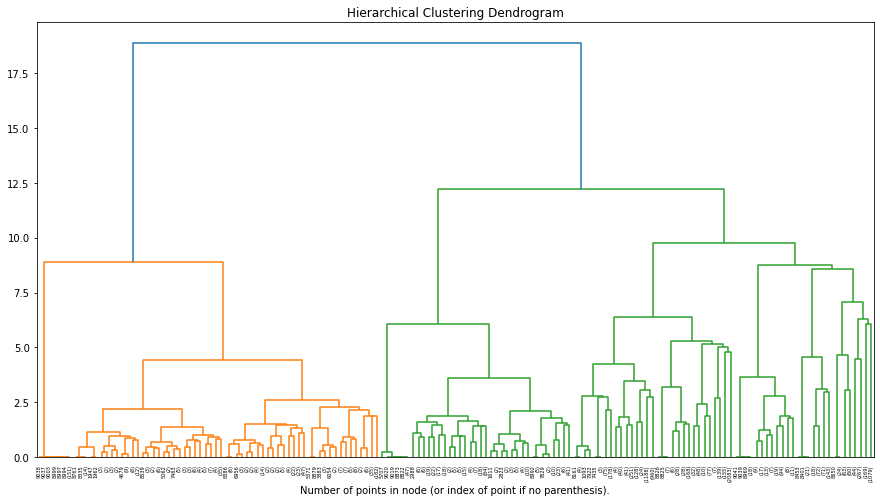

In [6]:
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig('Dendogram.png',dpi=300)
plt.show()

In [7]:
model.labels_.max()

11

In [8]:
campsite_grouped.insert(0, 'Agg_Cluster_Labels', model.labels_)
df_RV = df_RV.reset_index().set_index('Latitude')
campsite_grouped = campsite_grouped.set_index('Latitude')

In [9]:
df_RV['Agg_Cluster_Labels'] = campsite_grouped['Agg_Cluster_Labels']
df_RV = df_RV.reset_index()
df_RV

,Latitude,index,Campsite_Name,Longitude,Agg_Cluster_Labels
0,55.249428,0,'KSAN Historical Village Campground,-127.679933,1.0
1,44.030277,1,10 Acres Campground and RV Park,-73.403468,8.0
2,44.276788,2,1000 Islands Campground,-75.997158,1.0
3,44.350050,3,1000 Islands Camping Resort,-76.054170,0.0
4,43.891877,4,1000 Islands/Association Island K O A,-76.216943,1.0
...,...,...,...,...,...
16971,48.847923,16972,Zippel Bay SP,-94.849806,NaN
16972,35.603549,16973,Zooland Family Campground,-79.850677,NaN
16973,44.301126,16974,Zumbro Bottoms Horse Campground,-92.122085,NaN
16974,35.224768,16975,Zuni Village RV Park,-114.014515,NaN


In [10]:
campsite_grouped

,Agg_Cluster_Labels,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Latitude,,,,,,,,,,,,,,,,,,,,,
19.136683,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19.501292,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19.734633,8,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20.026883,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21.071786,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64.962006,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64.997376,5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65.053898,1,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
range_i = list(range(1,model.labels_.max()+2))
range_labels = []
for i in range_i:
    range_labels.append(str(i-1))
range_labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

In [12]:
range_i = list(range(1,model.labels_.max()+2))
df_clusters = []
df_clusters_stats = []
top_ten = []
for cluster in range_i:
    df_clusters.append(campsite_grouped[campsite_grouped['Agg_Cluster_Labels'] == cluster-1])
    cols = (df_clusters[-1] != 0).any()
    df_clusters[-1] = df_clusters[-1][cols[cols].index]
    try:
        df_clusters_stats.append(df_clusters[-1].drop(['Agg_Cluster_Labels'],1).describe().T.sort_values(by='mean', ascending=False))
    except:
        df_clusters_stats.append(df_clusters[-1].describe().T.sort_values(by='mean', ascending=False))
    temp = {}
    temp['name'] = 'Cluster {}'.format(cluster-1)
    lo = 0
    for top in df_clusters_stats[-1].iloc[:10].reset_index()['index'].tolist():
        lo = lo+1
        temp[str(lo)] = top
    top_ten.append(temp)
    print(cluster)
df_top_ten = pd.DataFrame(top_ten).set_index(['name'])
df_top_ten

1
2
3
4
5
6
7
8
9
10
11
12


,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
Cluster 0,Campground,Park,Golf Course,River,Mountain,Trail,Farm,Lake,Business Service,Post Office
Cluster 1,American Restaurant,Campground,Hotel,Convenience Store,Restaurant,Harbor / Marina,Bar,Grocery Store,Resort,Home Service
Cluster 2,Construction & Landscaping,Campground,Lake,Auto Workshop,Garden Center,Home Service,Restaurant,Other Repair Shop,Grocery Store,Business Service
Cluster 3,State / Provincial Park,Campground,Park,Trail,Golf Course,American Restaurant,Home Service,Construction & Landscaping,Bookstore,Restaurant
Cluster 4,Beach,Campground,Boat or Ferry,Lake,National Park,Harbor / Marina,Trail,State / Provincial Park,Scenic Lookout,Resort
Cluster 5,Trail,Campground,State / Provincial Park,Mountain,National Park,Tourist Information Center,Park,Food,Lake,Scenic Lookout
Cluster 6,Lake,Campground,Harbor / Marina,State / Provincial Park,American Restaurant,Scenic Lookout,Golf Course,Convenience Store,Park,Hotel
Cluster 7,Campground,Lake,Home Service,Trail,Convenience Store,Beach,Construction & Landscaping,State / Provincial Park,Hotel,Forest
Cluster 8,Fast Food Restaurant,Gas Station,Pizza Place,Sandwich Place,Discount Store,Coffee Shop,Convenience Store,Grocery Store,American Restaurant,Mexican Restaurant


In [13]:
con = sqlite3.connect('Campsite_data_4k-all.db')
df_top_ten.reset_index().to_sql('Agg_top_ten',con,if_exists='replace')
con.close()

In [33]:
# create map of RV parks using latitude and longitude values
latitude = df_RV['Latitude'].mean()
longitude = df_RV['Longitude'].mean()
map_national_RV_parks_clusters = {}
for cluster in df_RV.groupby('Agg_Cluster_Labels').count().reset_index()['Agg_Cluster_Labels'].tolist():
    
    map_national_RV_parks_clusters[cluster] = folium.Map(location=[latitude, longitude], zoom_start=4)

    # add markers to map
    marker_cluster_clusters = {}
    marker_cluster_clusters[cluster] = folium.plugins.MarkerCluster().add_to(map_national_RV_parks_clusters[cluster])
    for lat, lng, name in zip(df_RV[df_RV['Agg_Cluster_Labels']==cluster]['Latitude'], df_RV[df_RV['Agg_Cluster_Labels']==cluster]['Longitude'], df_RV.reset_index()[df_RV['Agg_Cluster_Labels']==cluster]['Campsite_Name']):
        alphanumeric = [character for character in name if character.isalnum()]
        name = "".join(alphanumeric)
        label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
        #label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_cluster_clusters[cluster])  

    map_national_RV_parks_clusters[cluster].save('Agg/Cluster_{}.html'.format(int(cluster)))

In [32]:

# create map of RV parks using latitude and longitude values
latitude = df_RV['Latitude'].mean()
longitude = df_RV['Longitude'].mean()
map_national_RV_parks2 = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
marker_cluster = folium.plugins.MarkerCluster().add_to(map_national_RV_parks2)
for lat, lng, name in zip(df_temp['Latitude'], df_temp['Longitude'], df_temp['Campsite_Name']):
    alphanumeric = [character for character in name if character.isalnum()]
    name = "".join(alphanumeric)
    label = "<a  target='_blank' href='https://www.google.com/search?q={}'>{}</a>".format(name.replace(' ','%20'),name)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(marker_cluster)  

map_national_RV_parks2

In [28]:
df_temp.reset_index()

,level_0,Latitude,index,Campsite_Name,Longitude,Agg_Cluster_Labels
0,3,44.350050,3,1000 Islands Camping Resort,-76.054170,0.0
1,17,44.068518,17,24 Express Campground,-102.449284,0.0
2,26,37.819286,26,4 Guys RV Park at the Gorge,-83.723770,0.0
3,30,41.063630,30,4th Pumping Station Campground (County),-90.968287,0.0
4,41,49.145339,41,8 Flags RV Park,-112.083431,0.0
...,...,...,...,...,...,...
1076,15454,25.893092,15455,Trail Lakes Campgrounds,-81.278561,0.0
1077,15459,37.488670,15460,Trail of Tears State Forest (Tents only),-89.346552,0.0
1078,15497,38.970887,15498,Travel Port Campground,-105.344306,0.0
1079,15505,31.751306,15506,Travelers N Park and Campground,-98.921703,0.0


In [15]:
df_RV.groupby('Agg_Cluster_Labels').count()

,Latitude,index,Campsite_Name,Longitude
Agg_Cluster_Labels,,,,
0.0,1081,1081,1081,1081
1.0,2795,2795,2795,2795
2.0,328,328,328,328
3.0,168,168,168,168
4.0,311,311,311,311
5.0,200,200,200,200
6.0,347,347,347,347
7.0,547,547,547,547
8.0,2911,2911,2911,2911


In [16]:
con = sqlite3.connect('Campsite_data_4k-all.db')
df_RV.to_sql('Agg',con,if_exists='replace')
campsite_grouped.reset_index().to_sql('Agg_grouped',con,if_exists='replace')
con.close()

/home/theia/.local/lib/python3.6/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,
